# Funções de perda (*loss functions*)

Neste código iremos analisar diferentes funções de perda (também conhecidas como *loss functions*) que são usadas para avaliar a rede no estado atual.

Funções de perda, também conhecidas como *loss functions*, são muito importantes para o aprendizagem de máquinas, pois servem como uma forma de medir a distância ou a diferença entre a saída prevista de um modelo e o seu valor real, auxiliando então no treino no modelo.

Diversas funções de perda foram propostas ao longo do tempo para diferentes tipos de problemas.
Algumas dessas funções foram propostas para auxiliar no treino de modelos de regressão linear, como as *loss* [L1](https://pytorch.org/docs/stable/nn.html#l1loss), [L2](https://pytorch.org/docs/stable/nn.html#mseloss) e [Huber](https://pytorch.org/docs/stable/nn.html#smoothl1loss).
Outras foram propostas para serem usadas em problemas de classificação, como a mais comum de todas [Cross-Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss).

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1ITV4Ikw0NP39p1KNFkt46LWwnhzLKf7h">
</p>


## Preâmbulo

In [2]:
import torch
import torch.nn.functional as F
import torchvision

from torchvision import datasets, transforms
from torch import optim, nn

from sklearn.model_selection import train_test_split

import numpy as np

import os
import sys
import time

In [3]:
import matplotlib.pyplot as plt
plt.ion()

In [4]:
# Test if GPU is avaliable, if not, use cpu instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = torch.cuda.device_count()
devices_ids = list(range(n))
devices_ids

[0]

In [5]:
## carregando dados básicos

# dados sintéticos somente para 
def synthetic_regression_data(w, b, num_examples):
    """generate y = X w + b + noise"""
    X = np.random.normal(scale=1, size=(num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(scale=0.01, size=y.shape)
    return torch.FloatTensor(X), torch.FloatTensor(y)

# código para carregar o dataset do MNIST
# http://yann.lecun.com/exdb/mnist/
def load_data_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.pytorch', 'datasets', 'fashion-mnist')):
    """Download the Fashion-MNIST dataset and then load into memory."""
    root = os.path.expanduser(root)
    transformer = []
    if resize:
        transformer += [transforms.Resize(resize)]
    transformer += [transforms.ToTensor()]
    transformer = transforms.Compose(transformer)

    mnist_train = datasets.MNIST(root=root, train=True,download=True, transform=transformer)
    mnist_test = datasets.MNIST(root=root, train=False,download=True, transform=transformer)
    num_workers = 0 if sys.platform.startswith('win32') else 4



    train_iter = torch.utils.data.DataLoader(mnist_train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter

In [6]:
# funções básicas

def load_array(features, labels, batch_size, is_train=True):
    """Construct a data loader"""
    dataset = torch.utils.data.TensorDataset(features, labels)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

          
# Função para inicializar pesos da rede
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.01) # valores iniciais são uma normal

## *Loss* L2

O função de custo chamada L2 (também conhecida como *Mean Squared Error* -- MSE) é, talvez, a função de perda mais simples e comum. 
Essa função é representada simplesmente pela média do quadrado da diferença entre as previsões do modelo e o *ground-truth*.
Essa função nunca terá valores negativos, pois a diferença calculada será sempre elevado à segunda potência.

Formalmente, dado a valor real $y$, e a predição feita pelo modelo $\hat{y}$, a *loss* L2 é definida pela seguinte equação:

$$\mathcal{l}_2^i(w, b) = \frac{1}{2} (\hat{y}^i - y^i)^2 $$

A constante $1/2$ é apenas por conveniência matemática, garantindo que depois de tomarmos a derivada dessa função, o coeficiente constante será de $1$.

A grande vantagem dessa função é que ela garante que o modelo treinado não tenha previsões discrepantes com erros enormes, já que ela atribui maior peso a esses erros devido à parte quadrática da função.
Entretanto, isso gera a desvantagem dessa função de custo, pois se o modelo faz uma única previsão muito ruim, a parte quadrática da função aumenta o erro consideravelmente.
No entanto, em muitos casos práticos, não nos importamos muito com esses poucos valores discrepantes e buscamos um modelo mais abrangente que tenha um bom desempenho na maioria.

Para tentar garantir a qualidade do modelo em todo o conjunto de dados, podemos simplesmente calcular a média das perdas no conjunto de treinamento:

$$\mathcal{L}(w, b) = \frac{1}{n} \sum_i^N \mathcal{l}^{i}_2(w, b) $$

### Implementação

Em frameworks atuais (como no MxNet, TensorFlow, e PyTorch), a implementação de funções de custo comuns, como a L2, são diretas e muitos simples.

**Um exemplo é mostrado abaixo utilizando o framework PyTorch.**

In [7]:
seed = [2, -3.4]
seed_gt = 4.2
features, labels = synthetic_regression_data(seed, seed_gt, 1000)
  
batch_size = 10
data_iter = load_array(features, labels, batch_size)

# arquitetura super simples
net = nn.Sequential(
    nn.Linear(2,1)
)

net.apply(weights_init)
net.to(device) # diz para a rede que ela deve ser treinada na GPU

loss = nn.MSELoss()  # loss L2
trainer = optim.SGD(net.parameters(), lr=0.03)

# treino
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    loss_sum = 0.0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X).view(batch_size)
        l = loss(y_hat, y)
        l.backward()
        trainer.step()
        trainer.zero_grad()
        loss_sum += l.item()
    print('epoch %d, loss: %f' % (epoch, l.mean().item()))

for i in range(995, 999):
  y_hat = net(features[i:i+1, :].to(device))
  print(y_hat, labels[i], labels[i] - y_hat)

epoch 1, loss: 0.000332
epoch 2, loss: 0.000111
epoch 3, loss: 0.000074
tensor([[1.1949]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(1.1914) tensor([[-0.0036]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[5.7190]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(5.7206) tensor([[0.0016]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[4.5507]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(4.5521) tensor([[0.0014]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[8.3412]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(8.3215) tensor([[-0.0197]], device='cuda:0', grad_fn=<SubBackward0>)


In [8]:
loss(net(features[:10, :].to(device)), labels[:10].to(device))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(21.1225, device='cuda:0', grad_fn=<MseLossBackward>)

## *Loss* L1

A função de custo L1 é apenas ligeiramente diferente da L2, mas fornece curiosamente propriedades quase exatamente opostas!
Essa função é representada pelo valor absoluto da diferença entre as previsões do modelo e o *ground-truth*.

Essa função, assim como o *loss* L2, nunca será negativo, pois neste caso estamos sempre assumindo o valor absoluto dos erros.
Formalmente, dado a valor real (*ground-truth*) $y$, e a predição feita pelo modelo $\hat{y}$, a *loss* L1 é definida pela seguinte equação:

$$\mathcal{l}_1^i(w, b) = \sum_i |\hat{y}^i - y^i| $$

A grande vantagem da função de custo L1 cobre diretamente a desvantagem do *loss* L2.
Em outras palaras, como estamos trabalhando com o valor absoluto, todos os erros serão ponderados na mesma escala linear.
Assim, ao contrário do *loss* L2, não estamos colocando muito peso nos valores com grande discrepância e a função de perda fornece uma medida genérica e uniforme do desempenho do modelo.

Por outro lado, a desvantagem desta função é, para alguns casos, não dar pesos diferentes para específico valores discrepantes. Por exemplo, os erros relativamente grandes provenientes dos *outliers* acabam sendo ponderados exatamente como erros menores. Isso pode resultar em nosso modelo sendo ótimo na maior parte do tempo, mas fazendo algumas previsões muito ruins de vez em quando.

Essa função pode ser facilmente implementada no PyTorch, como pode ser visto [aqui](https://pytorch.org/docs/stable/nn.html#l1loss).

In [9]:
seed = [2, -3.4]
seed_gt = 4.2
features, labels = synthetic_regression_data(seed, seed_gt, 1000)
  
batch_size = 10
data_iter = load_array(features, labels, batch_size)

# arquitetura super simples
net = nn.Sequential(
    nn.Linear(2,1)
)

net.apply(weights_init)
net.to(device) # diz para a rede que ela deve ser treinada na GPU

loss = nn.L1Loss()  # loss L1
trainer = optim.SGD(net.parameters(), lr=0.03)

# treino
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    loss_sum = 0.0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X).view(batch_size)
        l = loss(y_hat, y)
        l.backward()
        trainer.step()
        trainer.zero_grad()
        loss_sum += l.item()
    print('epoch %d, loss: %f' % (epoch, l.mean().item()))

for i in range(995, 999):
  y_hat = net(features[i:i+1, :].to(device))
  print(y_hat, labels[i], labels[i] - y_hat)

epoch 1, loss: 2.595627
epoch 2, loss: 0.779061
epoch 3, loss: 0.008881
tensor([[4.3999]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(4.4242) tensor([[0.0243]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[8.4831]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(8.4762) tensor([[-0.0069]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[7.1690]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(7.1838) tensor([[0.0148]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[1.2621]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(1.2605) tensor([[-0.0017]], device='cuda:0', grad_fn=<SubBackward0>)


## Huber *Loss* 

Vimos que a função de perda L2 tem certas vantangens (como conseguir aprender *outliers*), enquanto o *loss* L1 tem outros benefícios, como ignorar os *outliers*.
Porém, existe uma forma de combinar e agregar os benefícios das duas?

Sim! A Huber *Loss* oferece o melhor dos dois mundos, equilibrando as funções de perda L1 e L2 juntos. 
Formalmente, dado a valor real (*ground-truth*) $y$, e a predição feita pelo modelo $\hat{y}$, a Huber *Loss* é definida pela seguinte equação:

$$
l_H^i(w, b) = \sum_i \begin{cases}
                                        \frac{1}{2\rho} (\hat{y}^i - y^i)^2, & \text{if } |\hat{y}^i - y^i| < \rho\\
                                        |\hat{y}^i - y^i| - \frac{\rho}{2},  & \text{otherwise}
\end{cases}
$$
, onde $\rho$ é uma constance que define a margem.
O que essa equação essencialmente diz é: para valores de perda menores que $\rho$, use o *loss& L2; para valores de perda maiores que delta, use a função de custo L1.
Isso efetivamente combina o melhor dos dois mundos das duas funções de perda!

O uso da função de custo L1 para valores maiores reduz o peso que colocamos em valores discrepantes para que possamos obter um modelo completo. Ao mesmo tempo, usamos o *loss* L2 para valores menores de perda para manter uma função quadrática próxima ao centro.

Essa função pode ser facilmente implementada no PyTorch, como pode ser visto [aqui](https://pytorch.org/docs/stable/nn.html#smoothl1loss).

In [10]:
seed = [2, -3.4]
seed_gt = 4.2
features, labels = synthetic_regression_data(seed, seed_gt, 1000)
  
batch_size = 10
data_iter = load_array(features, labels, batch_size)

# arquitetura super simples
net = nn.Sequential(
    nn.Linear(2,1)
)

net.apply(weights_init)
net.to(device) # diz para a rede que ela deve ser treinada na GPU

loss = nn.SmoothL1Loss()  # loss L1
trainer = optim.SGD(net.parameters(), lr=0.03)

# treino
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    loss_sum = 0.0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X).view(batch_size)
        l = loss(y_hat, y)
        l.backward()
        trainer.step()
        trainer.zero_grad()
        loss_sum += l.item()
    print('epoch %d, loss: %f' % (epoch, l.mean().item()))

for i in range(995, 999):
  y_hat = net(features[i:i+1, :].to(device))
  print(y_hat, labels[i], labels[i] - y_hat)

epoch 1, loss: 1.890950
epoch 2, loss: 0.305951
epoch 3, loss: 0.000719
tensor([[7.9487]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(7.9753) tensor([[0.0266]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[5.4399]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(5.4727) tensor([[0.0328]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[6.1164]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(6.1228) tensor([[0.0064]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[6.4427]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(6.4610) tensor([[0.0183]], device='cuda:0', grad_fn=<SubBackward0>)


## *Loss Cross-Entropy*

O função de custo chamada *cross-entropy* ou *log loss* é a mais usada em problemas de classificação.
Essa função de perda, embasada pela teoria da informação, procura penalizar o *loss* baseado somente na classe correta de cada amostra.

Formalmente, dado a valor real $y$, e a predição feita pelo modelo $\hat{y}$, a *loss cross-entropy* é definida pela seguinte equação:

$$\mathcal{l}(w, b) = - \sum_i y_i log~\hat{y}_i $$
, onde $\hat{y}$ é saída normalizada (via [softmax](https://pytorch.org/docs/stable/nn.html#softmax)) da predição da rede.

Em particular, no somatório apenas um termo será diferente de zero e esse termo será o $log$ da probabilidade (normalizada via [softmax](https://pytorch.org/docs/stable/nn.html#softmax)) atribuída à classe correta. Intuitivamente, isso faz sentido porque $log (x)$ está aumentando no intervalo (0,1), então $−log (x)$ está diminuindo naquele intervalo.
Por exemplo, se tivermos uma amostra com probabilidade de 0.8 para o rótulo correto, o *loss* será penalizado em apenas 0.09.
Já se tivermos uma probabilidade menor de 0.08, o *loss* será penalizado em 1,09. Uma discussão sobre isso pode ser encontrada [aqui](https://discuss.pytorch.org/t/logsoftmax-vs-softmax/21386/2).

### Implementação

Em frameworks atuais (como no MxNet, TensorFlow, e PyTorch), a implementação da função de custo *cross-entropy* é direta.

**Um exemplo é mostrado abaixo utilizando o framework PyTorch.**

In [13]:
# Função usada para calcular acurácia
def evaluate_accuracy(data_iter, net, loss):
    """Evaluate accuracy of a model on the given data set."""

    acc_sum, n, l = torch.Tensor([0]), 0, 0
    
    with torch.no_grad():
      for X, y in data_iter:
          #y = y.astype('float32')
          X, y = X.to(device), y.to(device)
          y_hat = net(X)
          l += loss(y_hat, y).sum()
          acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
          n += y.size()[0]

    return acc_sum.item() / n, l.item() / len(data_iter)
  
# Função usada no treinamento e validação da rede
def train_validate(net, train_iter, test_iter, batch_size, trainer, loss,
                   num_epochs, type='regression'):
    print('training on', device)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            trainer.zero_grad()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.size()[0]
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss)
        if type == 'regression':
          print('epoch %d, train loss %.4f, test loss %.4f, time %.1f sec'
                % (epoch + 1, train_l_sum / len(train_iter), test_loss, time.time() - start))
        else:
          print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, '
              'test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / len(train_iter), train_acc_sum / n, test_loss, 
                 test_acc, time.time() - start))

In [12]:
# parâmetros: número de epochs, learning rate (ou taxa de aprendizado), e 
# tamanho do batch
num_epochs, lr, batch_size = 20, 0.5, 256

# rede simples somente com perceptrons e camadas densamente conectadas
net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10))  # sem softmax

net.apply(weights_init)
net.to(device) # diz para a rede que ela deve ser treinada na GPU

# função de custo (ou loss)
loss = nn.CrossEntropyLoss()

# carregamento do dado: mnist
train_iter, test_iter = load_data_mnist(batch_size)

# trainer do torch
trainer = optim.SGD(net.parameters(), lr=lr)

# treinamento e validação via pytorch

train_validate(net, train_iter, test_iter, batch_size, trainer, loss, num_epochs, 'classification')

Extracting /root/.pytorch/datasets/fashion-mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/MNIST/raw


Extracting /root/.pytorch/datasets/fashion-mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/MNIST/raw


Extracting /root/.pytorch/datasets/fashion-mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/MNIST/raw


Extracting /root/.pytorch/datasets/fashion-mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/MNIST/raw
Processing...
Done!



training on cuda


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


epoch 1, train loss 2.3019, train acc 0.111, test loss 2.3015, test acc 0.114, time 5.8 sec
epoch 2, train loss 2.1363, train acc 0.179, test loss 1.7226, test acc 0.309, time 5.4 sec
epoch 3, train loss 0.7102, train acc 0.754, test loss 0.4997, test acc 0.848, time 5.4 sec
epoch 4, train loss 0.2183, train acc 0.940, test loss 0.1915, test acc 0.943, time 5.4 sec
epoch 5, train loss 0.1388, train acc 0.960, test loss 0.1472, test acc 0.958, time 5.6 sec
epoch 6, train loss 0.1012, train acc 0.971, test loss 0.1249, test acc 0.963, time 5.4 sec
epoch 7, train loss 0.0773, train acc 0.977, test loss 0.1620, test acc 0.957, time 5.4 sec
epoch 8, train loss 0.0633, train acc 0.982, test loss 0.1444, test acc 0.961, time 5.3 sec
epoch 9, train loss 0.7980, train acc 0.840, test loss 0.2069, test acc 0.939, time 5.6 sec
epoch 10, train loss 0.1200, train acc 0.965, test loss 0.1156, test acc 0.966, time 5.5 sec
epoch 11, train loss 0.0871, train acc 0.974, test loss 0.1130, test acc 0.967,

label  4
output  tensor([[-7.2018, -7.2667,  0.7573, -7.3692, 18.5519, -0.6341, -0.3074,  5.1038,
         -5.6790,  3.7194]], device='cuda:0', grad_fn=<AddmmBackward>)
previsao  4


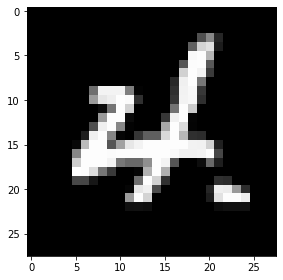

In [14]:
import skimage.io as io

for X, y in train_iter:
  X, y = X.to(device), y.to(device)
  io.imshow(X[0].cpu().numpy().squeeze())
  print('label ', y[0].item())
  y_hat = net(X[0])
  print('output ', y_hat)
  print('previsao ', y_hat.argmax().item())
  break